In [2]:
import os 
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import h5py
import numpy as np 


from scipy.integrate import simps
from scipy.optimize import curve_fit
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.lines import Line2D
from scipy.interpolate import CubicSpline
from PIL import Image

sns.set_context("talk")

%matplotlib inline

In [3]:


# Fit the resolution data to a polynomial for extrapolation
def poly_func(x, a, b, c):
    return a * x**2 + b * x + c

# Create a function to get resolution for any energy
def get_resolution(e,popt):
    return np.maximum(poly_func(e, *popt), 1e-10)  # Ensure non-zero resolution


# Perform Gaussian broadening using convolution with energy-dependent widths
def gaussian_broadening(dos, energy, sigmas):
    broadened_dos = np.zeros_like(dos)
    for i in range(len(energy)):
        # Create a Gaussian kernel centered at each energy point with width sigmas[i]
        kernel = np.exp(-0.5 * ((energy - energy[i]) / sigmas[i])**2)
        kernel /= simps(kernel, energy)  # Normalize the kernel to preserve area
        broadened_dos += dos[i] * kernel  # Convolve DOS with Gaussian kernel
    return broadened_dos

def apply_gaussian_broadening(dos_data,metric='dos total (nm2/ps)',unit_cell_atoms=1):
    energy = dos_data['Energy Transfer (meV)'].values
    dos = dos_data[metric].values

    resolution_data = pd.read_csv('../data/experiment/resolution.csv')
    res_energy = resolution_data['Energy (meV)'].values
    resolution = resolution_data['Resolution'].values
    popt, _ = curve_fit(poly_func, res_energy, resolution)
    
    # Create an array of sigmas for Gaussian broadening based on the resolution function
    sigmas = get_resolution(energy,popt) / np.sqrt(8 * np.log(2))  # Convert FWHM to sigma


    broadened_dos = gaussian_broadening(dos, energy, sigmas)

    # Area normalize both original and broadened DOS
    original_area = simps(dos, energy)
    broadened_area = simps(broadened_dos, energy)

    dos_normalized = dos / original_area
    broadened_dos_normalized = broadened_dos / broadened_area
    return 3*unit_cell_atoms*broadened_dos_normalized

In [4]:
df_Ice=pd.read_csv("../data/experiment/Ice_250K.csv")
df_Ice["Temperature (K)"]=250
df_Ice["Method"]="Experiment"
df_Ice["Max Normalized Count"]=df_Ice["Count"]/df_Ice["Count"].max()
df_Ice["Weight"]="Incoherent"
df_Ice["Data"]="Ice 250K"

df_H2O=pd.read_csv("../data/experiment/H2O_300K.csv")
df_H2O["Temperature (K)"]=300
df_H2O["Method"]="Experiment"
df_H2O["Max Normalized Count"]=df_H2O["Count"]/df_H2O["Count"].max()
df_H2O["Data"]="H2O 300K"
df_H2O["Weight"]="Incoherent"

results_directory={"../results/gromacs/H2O/results/md_prod_250/":250
                    ,"../results/gromacs/H2O/results/md_prod_300/":300
                   ,"../results/lammps/H2O/reaxff2022/results/mdanse/":-1
                  }
df_list=list()

min_energy=2
max_energy=400

for data_directory,temperature in results_directory.items():
    for filename in os.listdir(data_directory):
        if not "dos.h5" in filename:
            continue
        print(os.path.join(data_directory,filename))
        h5file=h5py.File(os.path.join(data_directory,filename))
        data_dict=dict()
        omega_shape=h5file["omega"][:].shape
        for k in h5file.keys():
            data_array=h5file[k][:]
            if data_array.shape != omega_shape or "_0" in k:
                continue
            units=h5file[k].attrs['units']
            data_dict["%s (%s)"%(k.replace("_"," "),units)]=data_array
        df_tmp=pd.DataFrame(data_dict).query("%f < `omega (rad/ps)` and `omega (rad/ps)` < %f"%(min_energy/0.6582,max_energy/0.6582))
        directory_split=data_directory.split("/")
        system=directory_split[3]
        df_tmp["Temperature (K)"]=temperature if temperature > 0 else int(filename.split("_")[-2].replace("K",""))
        
        df_tmp["Weight"]=None
        if "b_coherent" in filename:
            df_tmp["Weight"]="Coherent" 
        elif "b_incoherent" in filename:
            df_tmp["Weight"]="Incoherent"    
        software=directory_split[2]
        df_tmp["Method"]="MD:%s"%software
        df_tmp["Force Field"]="LJ" if software == "gromacs" else "reaxff2022"
        df_tmp["Energy Transfer (meV)"]=df_tmp["omega (rad/ps)"]*0.6582
        df_tmp["Normalized Count"]=apply_gaussian_broadening(df_tmp)
        for species in ["O","H"]:
            df_tmp[species]=apply_gaussian_broadening(df_tmp,"dos %s (nm2/ps)"%species)
            df_tmp[species]/=df_tmp[species].max()
        df_tmp["Max Normalized Count"]=df_tmp["Normalized Count"]/df_tmp["Normalized Count"].max()        
        df_tmp["Software"]=software
        df_tmp["System"]=system #.split("_")[0].replace("nanoparticle", "np")
        
        df_list.append(df_tmp)
        
df_list.append(df_Ice)
df_list.append(df_H2O)
df_dos_H2O=pd.concat(df_list,ignore_index=True)
df_dos_H2O

../results/gromacs/H2O/results/md_prod_250/b_coherent_dos.h5
../results/gromacs/H2O/results/md_prod_250/b_incoherent_dos.h5
../results/gromacs/H2O/results/md_prod_300/b_coherent_dos.h5
../results/gromacs/H2O/results/md_prod_300/b_incoherent_dos.h5
../results/lammps/H2O/reaxff2022/results/mdanse/nvt_phonon_b_coherent_250K_dos.h5
../results/lammps/H2O/reaxff2022/results/mdanse/nvt_phonon_b_coherent_300K_dos.h5
../results/lammps/H2O/reaxff2022/results/mdanse/nvt_phonon_b_incoherent_250K_dos.h5
../results/lammps/H2O/reaxff2022/results/mdanse/nvt_phonon_b_incoherent_300K_dos.h5


,dos H (nm2/ps),dos M (nm2/ps),dos O (nm2/ps),dos total (nm2/ps),omega (rad/ps),omega window (au),time window (au),Temperature (K),Weight,Method,...,Energy Transfer (meV),Normalized Count,O,H,Max Normalized Count,Software,System,Count,Error,Data
0,0.001578,0.001487,0.001553,0.001666,3.141907,0.0,1.0,250,Coherent,MD:gromacs,...,2.068003,0.005265,1.000000,0.441091,0.109333,gromacs,H2O,NaN,NaN,NaN
1,0.001907,0.001694,0.001734,0.002506,3.267583,0.0,1.0,250,Coherent,MD:gromacs,...,2.150723,0.004932,0.855880,0.386287,0.102420,gromacs,H2O,NaN,NaN,NaN
2,0.001527,0.001479,0.001560,0.001412,3.393259,0.0,1.0,250,Coherent,MD:gromacs,...,2.233443,0.003929,0.712713,0.318005,0.081589,gromacs,H2O,NaN,NaN,NaN
3,0.002018,0.001747,0.001781,0.002838,3.518936,0.0,1.0,250,Coherent,MD:gromacs,...,2.316164,0.004384,0.722595,0.330660,0.091039,gromacs,H2O,NaN,NaN,NaN
4,0.001753,0.001688,0.001762,0.001723,3.644612,0.0,1.0,250,Coherent,MD:gromacs,...,2.398884,0.004312,0.742721,0.335885,0.089555,gromacs,H2O,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300,Incoherent,Experiment,...,135.226000,NaN,NaN,NaN,0.624418,NaN,NaN,0.59532,0.01534,H2O 300K
39815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300,Incoherent,Experiment,...,138.260000,NaN,NaN,NaN,0.620820,NaN,NaN,0.59189,0.01518,H2O 300K
39816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300,Incoherent,Experiment,...,141.394000,NaN,NaN,NaN,0.614810,NaN,NaN,0.58616,0.01602,H2O 300K
39817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300,Incoherent,Experiment,...,144.633000,NaN,NaN,NaN,0.618324,NaN,NaN,0.58951,0.01720,H2O 300K


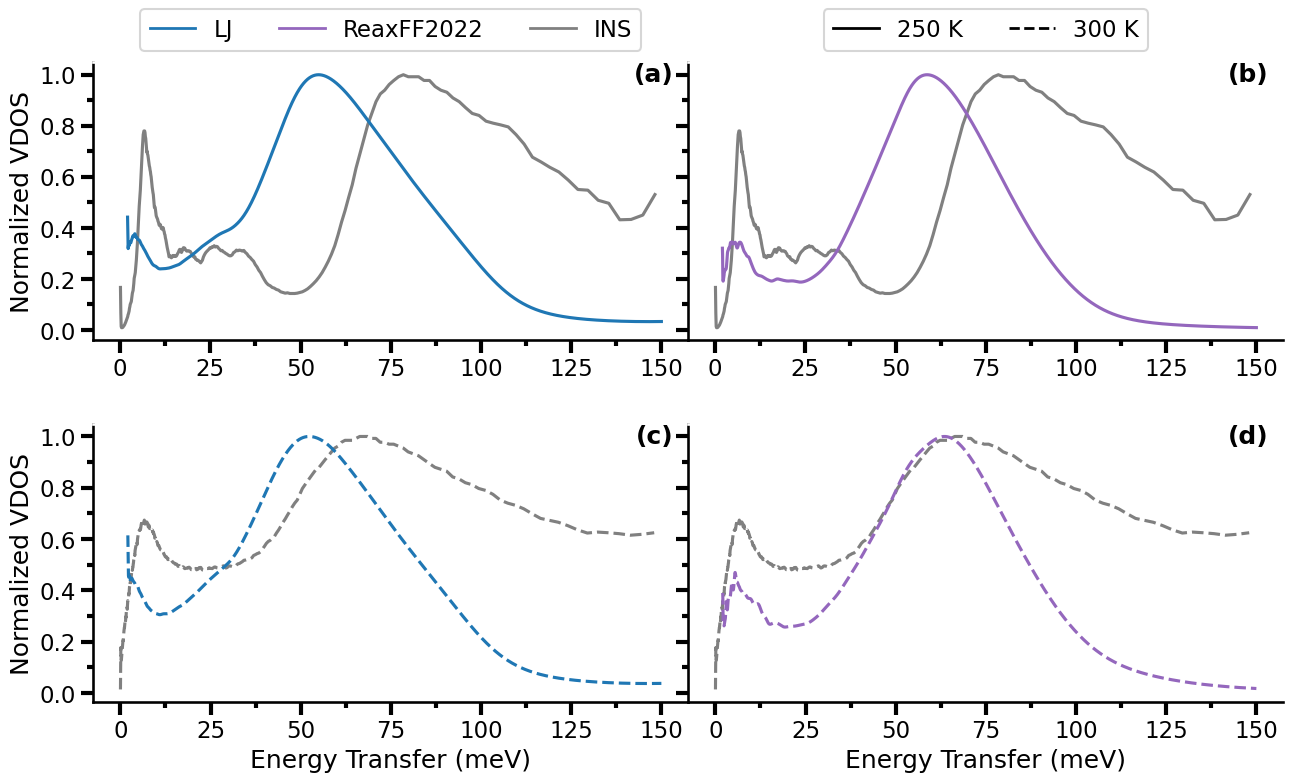

In [5]:
emin,emax=0,150
palette=[sns.color_palette("tab10")[0],sns.color_palette("tab10")[4]]


fig, axs = plt.subplots( nrows=2,ncols=2,figsize=(7*2,4*2)
                       # ,height_ratios =(3,2)
                       )
sns.set_context("talk")



labx=0.975
laby=1

index=["(%s)"%x for x in list("abcd")]

for i,temperature in enumerate(df_dos_H2O["Temperature (K)"].unique()):
    for j,force_field in enumerate(df_dos_H2O["Force Field"].dropna().unique()):

        ax=axs[i,j]
        ax.text(labx, laby, index[j+2*i],weight='bold' ,transform=ax.transAxes,va="top",ha="right")

        sns.lineplot(data=df_dos_H2O.query(" %f < `Energy Transfer (meV)` and `Energy Transfer (meV)` < %f and Weight== '%s' and `Temperature (K)` == %d and  Method=='Experiment'"%(emin,emax,"Incoherent",temperature))
                    ,y='Max Normalized Count'
                    ,x='Energy Transfer (meV)'
                    ,ax=ax
                   ,color="grey"
                    ,linestyle=["solid","dashed"][i]
                     #,marker="."
               )        
        
        sns.lineplot(data=df_dos_H2O.query(" %f < `Energy Transfer (meV)` and `Energy Transfer (meV)` < %f and Weight== '%s' and `Temperature (K)` == %d and `Force Field` == '%s'"%(emin,emax,"Incoherent",temperature,force_field))
                            ,y="Max Normalized Count"
                            ,x='Energy Transfer (meV)'
                            ,legend=False
                             ,color=palette[j]
                             ,linestyle=["solid","dashed"][i]
                             ,ax=ax
                       )


        ax.spines['bottom'].set_color('0')
        ax.spines['top'].set_color('1')
        ax.spines['right'].set_color('1')
        ax.spines['left'].set_color('0')
        ax.tick_params(direction='out', width=3, bottom=True, left=True)
        ax.grid(False)
        ax.set_ylabel("Normalized VDOS")
        if j > 0:
            ax.set_ylabel("")
            ax.set_yticklabels([])

        if i == 0:
            ax.set_xlabel("")
        
        if i+j == 0:
            custom_lines = [Line2D([0], [0], color=palette[0], lw=2),Line2D([0], [0], color=palette[1], lw=2)]+[Line2D([0], [0], color="grey", lw=2)]
            ax.legend(custom_lines,["LJ","ReaxFF2022","INS"])
            sns.move_legend(ax,'lower center',bbox_to_anchor=(0.5,1),ncol=3,bbox_transform=ax.transAxes)

        ax.xaxis.set_minor_locator(MultipleLocator(25/2))
        ax.yaxis.set_minor_locator(MultipleLocator(0.1))
        ax.tick_params(which='minor', length=4,width=3)

        if i== 0 and j > 0:            
            custom_lines = [Line2D([0], [0], color="black", lw=2)
                            ,Line2D([0], [0], color="black", lw=2,linestyle="dashed")]
            ax.legend(custom_lines,["250 K","300 K"])
            sns.move_legend(ax,'lower center',bbox_to_anchor=(0.5,1),ncol=2,bbox_transform=ax.transAxes)



# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.95, 
                    top=0.9, 
                    wspace=0., 
                    hspace=0.3
                   )

plt.savefig("../figures/figC1.pdf", pad_inches=0.2,bbox_inches="tight")